In [1]:
%matplotlib inline
from CartPole import CartPole, remap_angle, _remap_angle, _loss, loss
import autograd.numpy as np
from matplotlib.pyplot import ion, draw, Rectangle, Line2D
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from sklearn import linear_model
import cmath

# Week 1

In [2]:
initial_x = np.array([np.random.normal(), np.random.uniform(-10, 10), np.random.uniform(-np.pi,np.pi), np.random.uniform(-15,15)])
print(initial_x)

index_to_variable = {0 : 'cart_location', 1 : 'cart_velocity', 2 : 'pole_angle', 3 : 'pole_velocity'}

list_of_index_pairs = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
no_samples = 20
x_range_for_index = {0 : np.linspace(-5,5,no_samples), 1 : np.linspace(-10,10,no_samples), 2 : np.linspace(-np.pi,np.pi,no_samples), 3 : np.linspace(-15,15,no_samples)}

remap_angle = True

[ 1.20923222 -8.946241   -0.5222144   9.9651751 ]


## Task 1.1

In [3]:
def move_cart(initial_x, steps=10, visual=False, display_plots=True, remap_angle=True):
    """
    
    Parameters
    ----------
    initial_x : list-like
        [cart_location, cart_velocity, pole_angle, pole_velocity]
    steps: int
        number of steps taken
    visual: bool
        whether to show image of cart state
    display_plots: bool
        
    remap_angle: bool
        whether to remap angle to between pi -pi
        
    Returns
    -------
    list 
        x_history of state at discrete intervals
    """
    assert steps != 4, "Sorry, I don't like 4 steps"
    
    cp = CartPole(visual=visual)
    cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity = initial_x
    
    for step in range(steps):
        if visual: cp.drawPlot()
        cp.performAction()
        if remap_angle: cp.remap_angle()
        try: 
            x_history = np.vstack((x_history, np.array([cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity])))
        except:
            x_history = np.array((initial_x, [cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity]))
        
    t = range(x_history.shape[0]) if steps > 1 else 1
    
    if display_plots and steps > 1:
        fig, axs = plt.subplots(1, 3, figsize=(20, 5))
        
        axs[0].plot(t, [x[0] for x in x_history], label='cart_location')
        axs[0].plot(t, [x[1] for x in x_history], label='cart_velocity')
        axs[0].plot(t, [x[2] for x in x_history], label='pole_angle')
        axs[0].plot(t, [x[3] for x in x_history], label='pole_velocity')
        axs[0].legend()
        
        axs[1].plot([x[0] for x in x_history], [x[1] for x in x_history])
        axs[1].set_xlabel('cart_location')
        axs[1].set_ylabel('cart_velocity')
        
        axs[2].scatter([x[2] for x in x_history], [x[3] for x in x_history])
        axs[2].set_xlabel('pole_angle')
        axs[2].set_ylabel('pole_velocity')
        
        fig.tight_layout()
    
    elif display_plots and steps == 1: print("You're trying to plot over {} steps, which is not plottable, pick a number greater than 1".format(steps))
        
    if len(x_history) != 4: return x_history[-1]
    else: return x_history

### Simple oscillation around stable equilibrium

In [4]:
# history = move_cart([0,0,np.pi,0.5], steps=20, remap_angle=remap_angle)
# plt.savefig('plots/rollout_stable_equilibrium')

### Complete rotation of pendulum

In [5]:
# history = move_cart([0,0,0,1], steps=20, remap_angle=remap_angle)
# plt.savefig('plots/rollout_complete_rotation')

This is clearly a complete rotation, but the pole doesn't seem to ever hit 2pi because the pole angle is only sampled at discrete intervals therefore a value of exactly 2pi will never be recorded.

## Task 1.2

In [6]:
def plot_y():
    '''
    function for plotting y values when y is modelled 
    as X after one PerformAction step
    
    Parameters
    ----------
    index : int
        Which index of X (or variable) to scan over
    range_x : list-like
        Scan range
    '''

    fig, axs = plt.subplots(2, 2, figsize=(12, 9))

    for index in range(4):
        
        range_x = x_range_for_index[index]
        
        x = initial_x.copy()
        y_results = []
        
        for i in range_x:
            x[index] = i
            y = move_cart(x, steps=1, display_plots=False, remap_angle=remap_angle)
            y_results.append(y)
            
        axs[int(round((index+1)/4,0)),index%2].plot(range_x, [y[0] for y in y_results], label='cart_location')
        axs[int(round((index+1)/4,0)),index%2].plot(range_x, [y[1] for y in y_results], label='cart_velocity')
        axs[int(round((index+1)/4,0)),index%2].plot(range_x, [y[2] for y in y_results], label='pole_angle')
        axs[int(round((index+1)/4,0)),index%2].plot(range_x, [y[3] for y in y_results], label='pole_velocity')
        axs[int(round((index+1)/4,0)),index%2].set_ylabel('component of y values')
        axs[int(round((index+1)/4,0)),index%2].set_xlabel('{} initial values'.format(index_to_variable[index]))
        axs[int(round((index+1)/4,0)),index%2].legend()
        
    fig.tight_layout()

In [7]:
# plot_y()
# plt.savefig('plots/y_as_next_step')

The above plots are of Y modelled as X after one PerformAction

#### Modelling Y using Y = X(T) - X(0)

##### (i) scans of single variables

In [8]:
def plot_y_as_difference_in_x(model=None):
    '''
    function for plotting y values when y is modelled 
    as X(T) - X(0)
    
    Parameters
    ----------
    model : 
        linear regression model
    '''
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))

    for index in range(4):
        
        range_x = x_range_for_index[index]
        
        x = initial_x.copy()
        y_results = []
        x_0 = None
        x_t = None

        for i in range_x:
            x[index] = i
            x_t = np.array(move_cart(x, steps=1, display_plots=False, remap_angle=remap_angle))
            try:
                x_t_results = np.vstack((x_t_results, x_t))
                x_0 = np.vstack((x_0, x))
            except:
                x_t_results = x_t
                x_0 = x.copy()

        if model: predictions = model.predict(x_0)
        
        y_results = x_t_results - x_0
        y_results[:,2] = np.array([_remap_angle(theta) for theta in y_results[:,2]])
        
        axs[int(round((index+1)/4,0)),index%2].plot(range_x, [y[0] for y in y_results], label='c_l')
        axs[int(round((index+1)/4,0)),index%2].plot(range_x, [y[1] for y in y_results], label='c_v')
        axs[int(round((index+1)/4,0)),index%2].plot(range_x, [y[2] for y in y_results], label='p_a')
        axs[int(round((index+1)/4,0)),index%2].plot(range_x, [y[3] for y in y_results], label='p_v')
        if model:
            axs[int(round((index+1)/4,0)),index%2].scatter(range_x, [pred_[0] for pred_ in predictions], label='c_l_pred')
            axs[int(round((index+1)/4,0)),index%2].scatter(range_x, [pred_[1] for pred_ in predictions], label='c_v_pred')
            axs[int(round((index+1)/4,0)),index%2].scatter(range_x, [pred_[2] for pred_ in predictions], label='p_a_pred')
            axs[int(round((index+1)/4,0)),index%2].scatter(range_x, [pred_[3] for pred_ in predictions], label='p_v_pred')
        axs[int(round((index+1)/4,0)),index%2].set_ylabel('component of y values')
        axs[int(round((index+1)/4,0)),index%2].set_xlabel('{} initial values'.format(index_to_variable[index]))
        axs[int(round((index+1)/4,0)),index%2].legend()

    fig.suptitle('varying over {}'.format(index_to_variable[index]))
    fig.tight_layout()

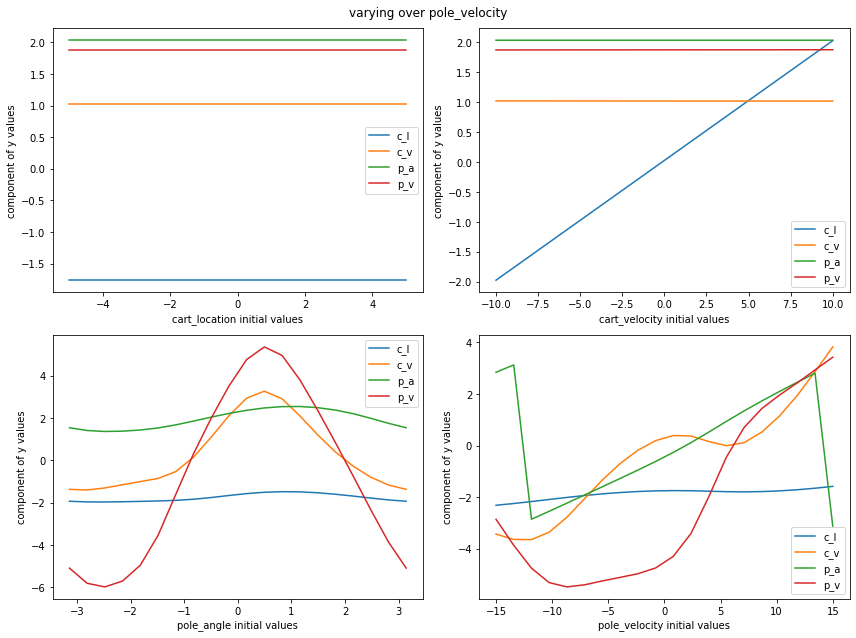

In [9]:
plot_y_as_difference_in_x()
# plt.savefig('plots/y_as_difference_scan_1')

##### (ii) contour plots

In [10]:
def range_x_pair_finder(index_pair):
    range_x_pair = []
    for index in index_pair:
        range_x_pair.append(x_range_for_index[index])
    return range_x_pair

In [11]:
def plot_y_contour_as_difference_in_x(index_pair, range_x_pair):
    '''
    function for plotting y contours when y is modelled 
    as X(T) - X(0) and 2 variables are scanned across 
    
    Parameters
    ----------
    index_pair : list-like of int
        Which index pair of X (or variables) to scan over
    range_x_pair : list-like of list-like
        Scan range of both variables
    '''
   
    index_1, index_2 = index_pair
    range_1, range_2 = range_x_pair
    
    x_0_grid = np.zeros((len(range_1),len(range_2),4))
    x_t_grid = np.zeros((len(range_1),len(range_2),4))
    
    for i,value_1 in enumerate(range_1):
        for j, value_2 in enumerate(range_2):
            x = initial_x.copy()
            x[index_1] = value_1
            x[index_2] = value_2
            x_0_grid[i,j] = x
            x_t_grid[i,j] = np.array(move_cart(x, steps=1, display_plots=False, remap_angle=True))
                            
    y_grid = x_t_grid - x_0_grid
    y_grid = np.moveaxis(y_grid, -1, 0)   
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    
    if index_pair == [2,3]:
        vmin = None
        vmax = None
    else:
        vmin = y_grid.min()
        vmax = y_grid.max()
    axs[0,0].contourf(range_1, range_2, y_grid[0].T, vmin=vmin, vmax=vmax)
    axs[0,0].set_title('cart_location')
    axs[0,0].set_xlabel('{} initial value'.format(index_to_variable[index_1]))
    axs[0,0].set_ylabel('{} initial value'.format(index_to_variable[index_2]))    
    axs[0,1].contourf(range_1, range_2, y_grid[1].T, vmin=vmin, vmax=vmax)
    axs[0,1].set_title('cart_velocity')
    axs[0,1].set_xlabel('{} initial value'.format(index_to_variable[index_1]))
    axs[0,1].set_ylabel('{} initial value'.format(index_to_variable[index_2]))
    axs[1,0].contourf(range_1, range_2, y_grid[2].T, vmin=vmin, vmax=vmax)
    axs[1,0].set_title('pole_angle')
    axs[1,0].set_xlabel('{} initial value'.format(index_to_variable[index_1]))
    axs[1,0].set_ylabel('{} initial value'.format(index_to_variable[index_2]))
    axs[1,1].contourf(range_1, range_2, y_grid[3].T, vmin=vmin, vmax=vmax)
    axs[1,1].set_title('pole_velocity')
    axs[1,1].set_xlabel('{} initial value'.format(index_to_variable[index_1]))
    axs[1,1].set_ylabel('{} initial value'.format(index_to_variable[index_2]))
    fig.tight_layout()

In [12]:
# for index_pair in list_of_index_pairs:
#     print('_____________________Plots of {} vs {}_____________________'.format(index_to_variable[index_pair[0]],index_to_variable[index_pair[1]]))
#     plot_y_contour_as_difference_in_x(index_pair, range_x_pair_finder(index_pair))
#     if index_pair == [0,1]: plt.savefig('plots/contour_plot_scan_over_{}_{}'.format(index_pair[0], index_pair[1]))
#     plt.show()
#     plt.close()

From these plots, we can see that:
1. Initial values that affect Y linearly are:

    Cart location

    Cart velocity


2. Initial values that affect Y non-linearly are:

    Pole angle
    
    Pole velocity
    

Clearly the cart location does not affect any of these Y values. 


## Task 1.3

In [13]:
def generate_data(n, steps=1):
    for i in range(n):
        try:
            x_ = np.array([np.random.normal(), np.random.uniform(-10, 10), np.random.uniform(-np.pi,np.pi), np.random.uniform(-15,15)])
            y_ = np.array(move_cart(x_, steps=steps, display_plots=False, remap_angle=remap_angle)) - x_
            x = np.vstack((x, x_))
            y = np.vstack((y, y_))

        except:
            x = np.array([np.random.normal(), np.random.uniform(-10, 10), np.random.uniform(-np.pi,np.pi), np.random.uniform(-15,15)])
            y = np.array(move_cart(x, steps=steps, display_plots=False, remap_angle=remap_angle)) - x
            
    return x,y

In [14]:
def plot_predictions(predictions, y_test, x_test):
    assert predictions.shape == y_test.shape, 'mismatched shapes {} {}'.format(predictions.shape, y_test.shape)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    axs[0,0].scatter([x[0] for x in x_test], [y[0] for y in y_test])
    axs[0,0].scatter([x[0] for x in x_test], [pred[0] for pred in predictions])
    axs[0,0].set_xlabel('X_cart_location')
    axs[0,0].set_ylabel('Y_cart_location')
    
    axs[0,1].scatter([x[1] for x in x_test], [y[1] for y in y_test], label='actual point')
    axs[0,1].scatter([x[1] for x in x_test], [pred[1] for pred in predictions], label='prediction')    
    axs[0,1].set_xlabel('X_cart_velocity')
    axs[0,1].set_ylabel('Y_cart_velocity')
    
    axs[1,0].scatter([x[2] for x in x_test], [y[2] for y in y_test])
    axs[1,0].scatter([x[2] for x in x_test], [pred[2] for pred in predictions])
    axs[1,0].set_xlabel('X_pole_angle')
    axs[1,0].set_ylabel('Y_pole_angle')
    
    axs[1,1].scatter([x[3] for x in x_test], [y[3] for y in y_test])
    axs[1,1].scatter([x[3] for x in x_test], [pred[3] for pred in predictions])
    axs[1,1].set_xlabel('X_pole_velocity')
    axs[1,1].set_ylabel('Y_pole_velocity')
    
    axs[0,1].legend()
    fig.tight_layout()
    

In [15]:
proportion_train = 0.6
n = 500
train_index = int(proportion_train*n)

x,y = generate_data(500)

x_train, y_train = x[:train_index], y[:train_index]
x_test, y_test = x[train_index:], y[train_index:]

x.shape,y[:,0].shape, x_train.shape, y_train.shape, x_test.shape, y_test.shape

((500, 4), (500,), (300, 4), (300, 4), (200, 4), (200, 4))

[0.08098802 0.02634406 0.12606543 0.95819033]


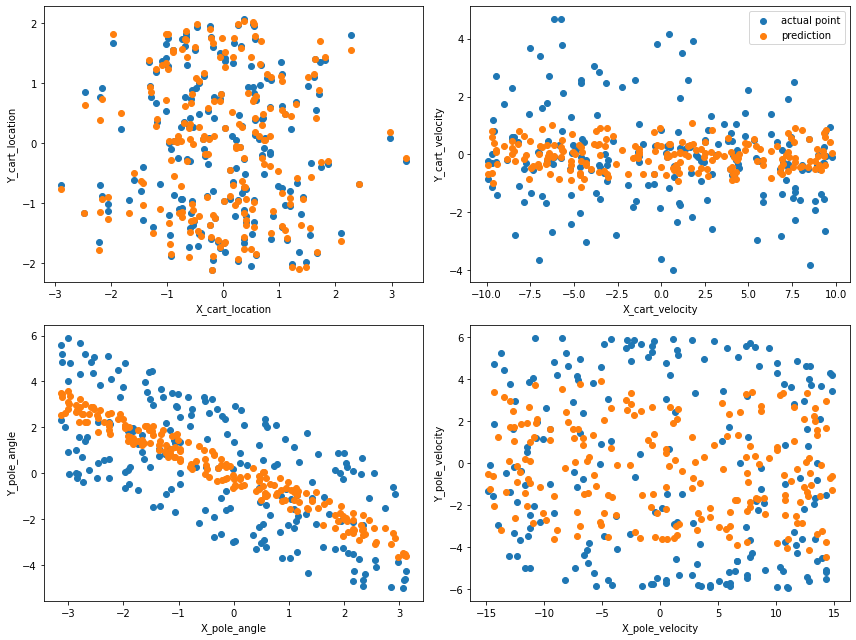

In [16]:
def predict(x_train, y_train, x_test):
    B = np.matmul(np.linalg.pinv(x_train),y_train)
    print(np.abs(np.linalg.eig(B)[0]))
    pred = np.matmul(x_test,B)
    return pred
    
predictions = predict(x_train, y_train, x_test)

plot_predictions(predictions, y_test, x_test)


In [17]:
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)


LinearRegression()

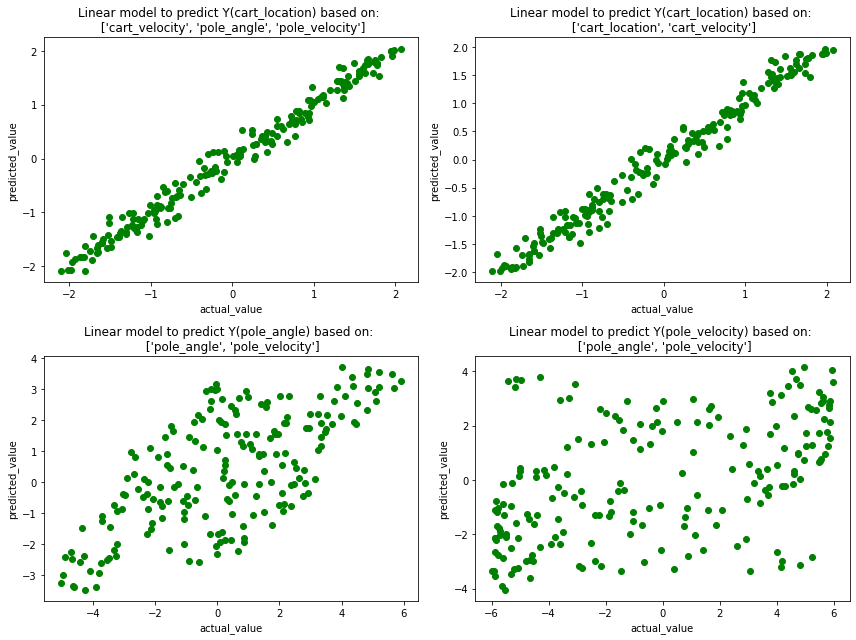

In [18]:
list_test_indices_and_output = [[1,2,3,0],[0,1,0],[2,3,2],[2,3,3]]
number_plots = len(list_test_indices_and_output)

fig, axs = plt.subplots((number_plots//2), 2, figsize=(12, 4.5*(number_plots//2)))
for i,indice_and_output in enumerate(list_test_indices_and_output):
    indices = indice_and_output[:-1]
    output = indice_and_output[-1]
    reg_ = linear_model.LinearRegression()
    reg_.fit(x_train[:,indices], y_train[:,output])
    for x,y in zip(x_test,y_test):
        pred = reg_.predict([x[indices]])
        axs[int(round((i+1)/4,0)),i%2].scatter(y[output], pred, color='g')
        axs[int(round((i+1)/4,0)),i%2].set_xlabel('actual_value')
        axs[int(round((i+1)/4,0)),i%2].set_ylabel('predicted_value')
        axs[int(round((i+1)/4,0)),i%2].set_title('Linear model to predict Y({}) based on: \n {}'.format(index_to_variable[output], str([index_to_variable[index] for index in indices])))
    fig.tight_layout()

plt.savefig('plots/linear_regression_model_different_inputs')

In [19]:
# plot_predictions(reg.predict(x_test), y_test, x_test)
# plt.savefig('plots/predictions_from_linear_model')

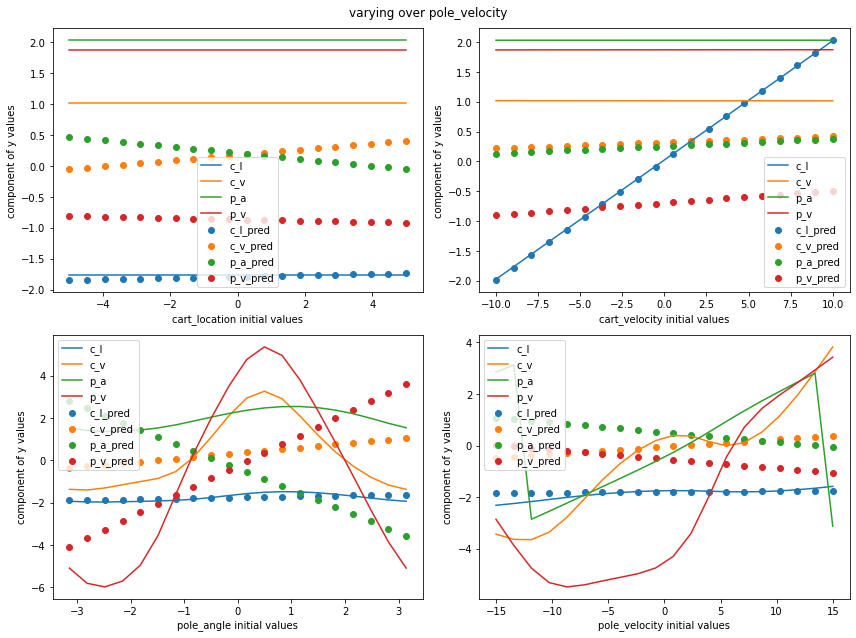

In [20]:
plot_y_as_difference_in_x(reg)
plt.savefig('plots/linear_regression_predictions_for_y_scanning_1')

# Task 1.4

In [21]:
def project_x_using_linear_model(initial_x, linear_model, steps, remap_angle=True):
    
    cp = CartPole()
    cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity = initial_x
    pred_ = None
    
    for step in range(steps):
        x_ = [cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity]
        cp.performAction()
        if remap_angle: cp.remap_angle()
        y_ = [cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity]
        if pred_ is not None: pred_ = x_ + linear_model.predict([x_])
            
        try:
            prediction_history = np.vstack((prediction_history, pred_))
            y_history = np.vstack((y_history, y_))
        except:
            assert all(x_) == all(initial_x), '{}_______{}'.format(x_, initial_x)
            pred_ = x_ + linear_model.predict([x_])
            prediction_history = np.vstack((x_, pred_))
            y_history = np.vstack((x_, y_))
            
    return prediction_history, y_history

In [22]:
def plot_prediction_vs_actual_over_time(prediction_history, y_history, title=None, filename=''):
    
    t = range(len(prediction_history))
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    axs[0,0].plot(t, [y[0] for y in y_history], label='actual values')
    axs[0,0].plot(t, [pred[0] for pred in prediction_history], label='predicted values')
    axs[0,0].set_ylabel('Y_cart_location')
    axs[0,0].set_xlabel('time_step')    
    axs[0,1].plot(t, [y[1] for y in y_history], label='actual values')
    axs[0,1].plot(t, [pred[1] for pred in prediction_history], label='predicted values')
    axs[0,1].set_ylabel('Y_cart_velocity')
    axs[0,1].set_xlabel('time_step')    
    axs[1,0].plot(t, [y[2] for y in y_history], label='actual values')
    axs[1,0].plot(t, [pred[2] for pred in prediction_history], label='predicted values')
    axs[1,0].set_ylabel('Y_pole_angle')
    axs[1,0].set_xlabel('time_step')
    axs[1,1].plot(t, [y[3] for y in y_history], label='actual values')
    axs[1,1].plot(t, [pred[3] for pred in prediction_history], label='predicted values')
    axs[1,1].set_ylabel('Y_pole_velocity')
    axs[1,1].set_xlabel('time_step')
    axs[0,1].legend(loc='upper right')
    if title: fig.suptitle(title)
    fig.tight_layout()
    plt.savefig('plots/linear_regression_model_{}_remap={}'.format(filename, remap_angle))
    

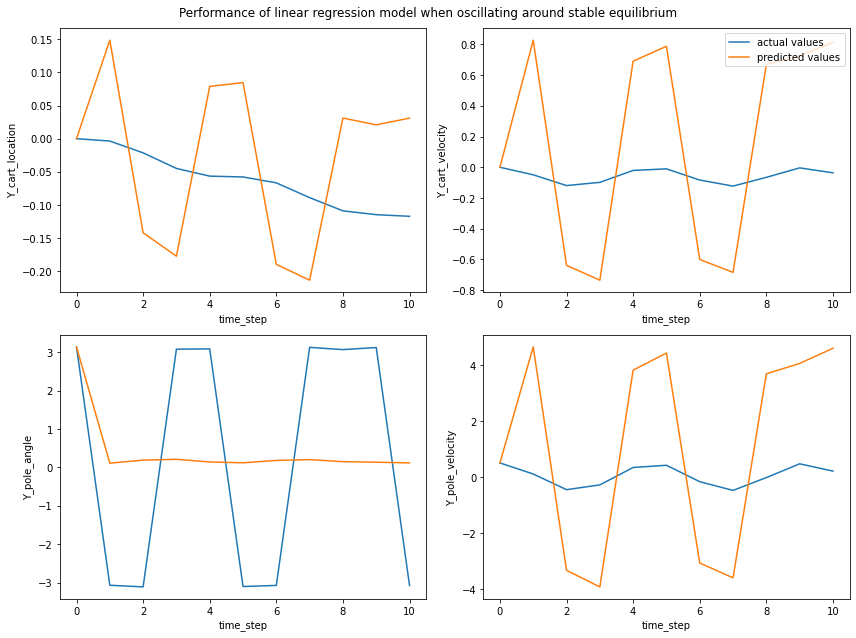

In [23]:
prediction_history, y_history = project_x_using_linear_model([0,0,np.pi,0.5], reg, 10)
plot_prediction_vs_actual_over_time(prediction_history, y_history, title='Performance of linear regression model when oscillating around stable equilibrium', filename='SHM')

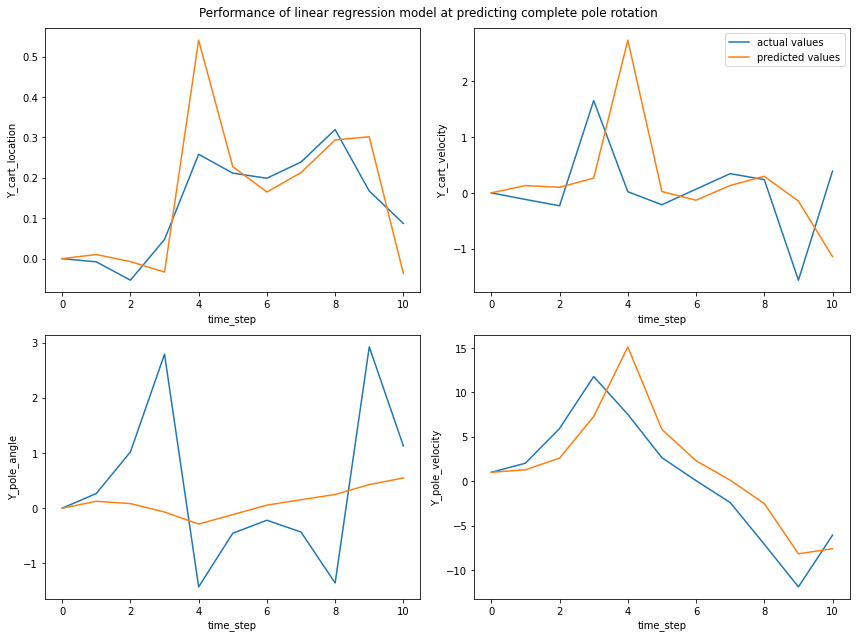

In [24]:
prediction_history, y_history = project_x_using_linear_model([0,0,0,1], reg, 10)
plot_prediction_vs_actual_over_time(prediction_history, y_history, title='Performance of linear regression model at predicting complete pole rotation', filename='complete_rotation')

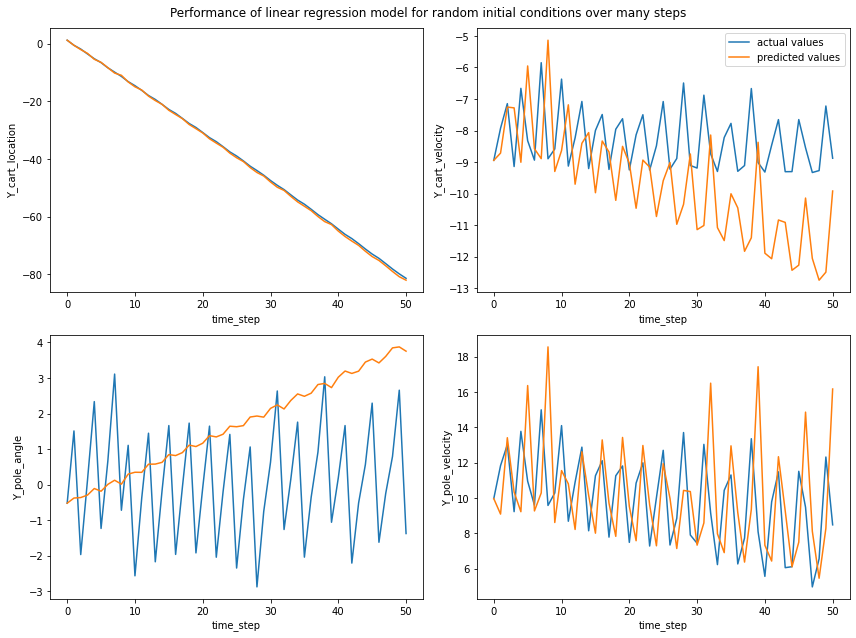

In [25]:
prediction_history, y_history = project_x_using_linear_model(initial_x, reg, 50)
plot_prediction_vs_actual_over_time(prediction_history, y_history, title='Performance of linear regression model for random initial conditions over many steps', filename='random_initial_conditions_many_steps')